In [1]:
import pandas as pd
import numpy as np
import math

predictive_train=pd.read_parquet('predictive_train.gzip') 
predictive_test=pd.read_parquet('predictive_test.gzip') 

cluster_treino=pd.read_csv('cluster_treino1.csv')
cluster_teste=pd.read_csv('cluster_teste1.csv')

predictive_train=predictive_train.merge(cluster_treino)
predictive_test=predictive_test.merge(cluster_teste)

In [2]:
import sys
sys.path.insert(1, '../Functions')
from check_missing import check_missing
from cramersv import *
from pearson import *
from encode import *
from Treat_Missing import *

In [3]:
predictive_train.type_card.value_counts()

classic    3
Name: type_card, dtype: int64

In [4]:
predictive_train.drop(['issued_date','type_disp','type_card','name','unemploymant_rate_96', 'ratio_crimes_96'],axis=1,inplace=True)
predictive_test.drop(['issued_date','type_disp','type_card','name','unemploymant_rate_95', 'ratio_crimes_95'],axis=1,inplace=True)

In [5]:
predictive_train.columns

Index(['client_id', 'disp_id', 'account_id', 'district_id_cli',
       'district_id_ac', 'ac_date', 'birth_date', 'loan_date', 'sex',
       'frequency', 'amount', 'duration', 'payments', 'card', 'loan',
       'nb_prod', 'status', 'region', 'no_inhabitants', 'no_cities',
       'ratio_urban_inhabitants', 'average_salary', 'unemploymant_rate_95',
       'no_enterpreneurs_per_1000_inhabitants', 'dif_district', 'rend_sum',
       'max_date', 'meses_trans', 'avg_wage_trans', 'fout_sum',
       'avg_fout_trans', 'balance_sum', 'avg_balance', 'avg_nr_ntrans',
       'avg_amt_ntrans', 'avg_nr_ptrans', 'avg_amt_ptrans', 'avg_ins',
       'avg_interest', 'avg_pension', 'avg_house', 'avg_ncard', 'bank_fee',
       'Age', 'loan_end', 'ac_maturity', 'Nb_muni', 'ratio_mun_499',
       'ratio_mun_500_1999', 'ratio_mun_2000_9999', 'ratio_mun_10000',
       'ratio_crimes_95', 'risk_trans', 'nr_rtrans', 'trans_date_max',
       'district_new', '2tit', 'cluster'],
      dtype='object')

## Oversampling no treino

## Missings

In [6]:
check_missing(predictive_train)

The dataframe has 58 columns.
 There are 12 columns that have missing values.
 There are 46 columns that have no missing values.
 
 Here is the list of variable having missing values: 
['rend_sum', 'avg_wage_trans', 'fout_sum', 'avg_fout_trans', 'avg_nr_ntrans', 'avg_amt_ntrans', 'avg_ins', 'avg_interest', 'avg_pension', 'avg_house', 'avg_ncard', 'nr_rtrans']


,# Missing Values,% Missing Values
avg_pension,211,100.0
avg_ncard,209,99.1
nr_rtrans,201,95.3
avg_ins,184,87.2
rend_sum,148,70.1
avg_wage_trans,148,70.1
avg_house,80,37.9
fout_sum,18,8.5
avg_fout_trans,18,8.5
avg_nr_ntrans,2,0.9


In [7]:
check_missing(predictive_test)

The dataframe has 58 columns.
 There are 9 columns that have missing values.
 There are 49 columns that have no missing values.
 
 Here is the list of variable having missing values: 
['rend_sum', 'avg_wage_trans', 'fout_sum', 'avg_fout_trans', 'avg_ins', 'avg_pension', 'avg_house', 'avg_ncard', 'nr_rtrans']


,# Missing Values,% Missing Values
avg_pension,117,100.0
avg_ncard,112,95.7
nr_rtrans,112,95.7
avg_ins,101,86.3
rend_sum,83,70.9
avg_wage_trans,83,70.9
avg_house,49,41.9
fout_sum,15,12.8
avg_fout_trans,15,12.8


In [8]:
num_0=['rend_sum', 'avg_wage_trans', 'fout_sum', 'avg_fout_trans', 'avg_ins', 'avg_pension', 
       'avg_house', 'avg_ncard', 'nr_rtrans','avg_nr_ntrans', 'avg_amt_ntrans', 'avg_interest']
Treat_Missing(df=predictive_train,var=[num_0],values=[0])
Treat_Missing(df=predictive_test,var=[num_0],values=[0])

'Finished.'

In [9]:
check_missing(predictive_train)

The dataframe has 58 columns.
 There are 0 columns that have missing values.
 There are 58 columns that have no missing values.
 
 Here is the list of variable having missing values: 
[]


,# Missing Values,% Missing Values


In [10]:
train_cat=predictive_train.select_dtypes(include=['object'])

In [11]:
train_cat.describe()

,sex,frequency,region,district_new
count,211,211,211,211
unique,2,3,8,8
top,M,monthly issuance,south Moravia,Other
freq,107,169,43,152


../Functions\encode.py:33: UserWarning: Attempting to set identical bottom == top == 0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(bottom + 0.5, top - 0.5)


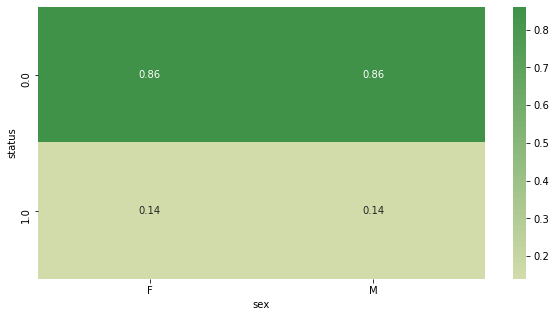

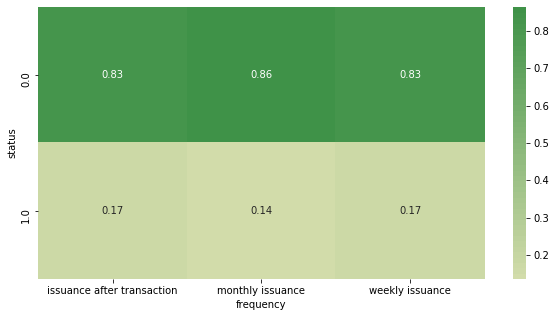

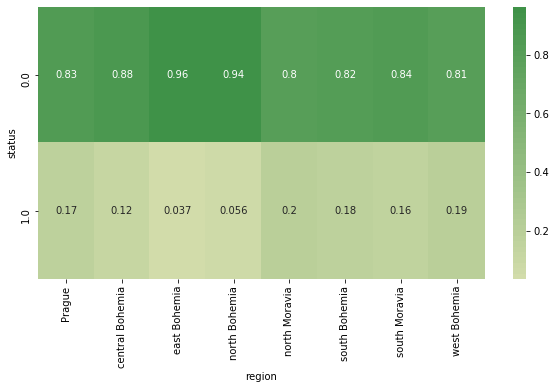

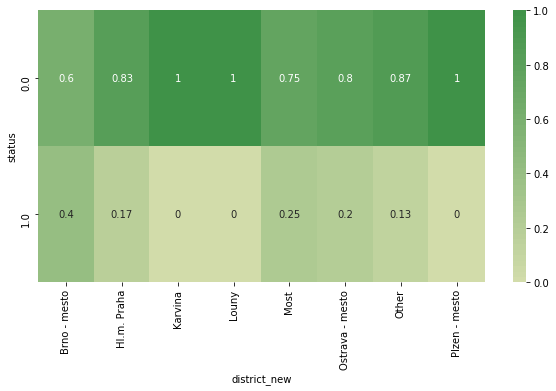

[{'M': 0, 'F': 1},
 {'monthly issuance': 0,
  'issuance after transaction': 1,
  'weekly issuance': 2},
 {'east Bohemia': 0,
  'north Bohemia': 1,
  'central Bohemia': 2,
  'south Moravia': 3,
  'Prague': 4,
  'south Bohemia': 5,
  'west Bohemia': 6,
  'north Moravia': 7},
 {'Karvina': 0,
  'Louny': 1,
  'Plzen - mesto': 2,
  'Other': 3,
  'Hl.m. Praha': 4,
  'Ostrava - mesto': 5,
  'Most': 6,
  'Brno - mesto': 7}]

In [12]:
encode(df=predictive_train, cat_var_labels=train_cat.columns, target_var='status', target_label=1)

In [13]:
predictive_train[train_cat.columns].dtypes

sex             int64
frequency       int64
region          int64
district_new    int64
dtype: object

In [14]:
from imblearn.over_sampling import SMOTE
X=predictive_train[['amount', 'duration', 'payments', 'card', 'loan', 'nb_prod', 
       'no_inhabitants', 'no_cities', 'ratio_urban_inhabitants',
       'average_salary', 'unemploymant_rate_95', 
       'no_enterpreneurs_per_1000_inhabitants', 'dif_district', 'rend_sum',
       'meses_trans', 'avg_wage_trans', 'fout_sum', 'avg_fout_trans',
       'balance_sum', 'avg_balance', 'avg_nr_ntrans', 'avg_amt_ntrans',
       'avg_nr_ptrans', 'avg_amt_ptrans', 'avg_ins', 'avg_interest',
       'avg_pension', 'avg_house', 'avg_ncard', 'bank_fee', 'Age',
       'ac_maturity', 'Nb_muni', 'ratio_mun_499', 'ratio_mun_500_1999',
       'ratio_mun_2000_9999', 'ratio_mun_10000', 'ratio_crimes_95',
       'risk_trans', 'nr_rtrans', 'cluster',
                    'sex', 'frequency', 'region', 'district_new']]
y=predictive_train['status']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [15]:
predictive_train=pd.concat([X, y], axis=1, sort=False)
predictive_train.head()

,amount,duration,payments,card,loan,nb_prod,no_inhabitants,no_cities,ratio_urban_inhabitants,average_salary,...,ratio_mun_10000,ratio_crimes_95,risk_trans,nr_rtrans,cluster,sex,frequency,region,district_new,status
0,80952.0,24.0,3373.0,0.0,1.0,1.0,1204953,1,100.0,12541,...,1.000000,0.071104,0.0,0.0,0,0,0,4,4,0
1,104808.0,12.0,8734.0,0.0,1.0,1.0,125832,5,48.3,8512,...,0.015228,0.017857,0.0,0.0,0,0,0,3,3,0
2,123696.0,48.0,2577.0,0.0,1.0,1.0,124605,8,46.0,8772,...,0.014706,0.022904,0.0,0.0,0,0,0,3,3,0
3,100980.0,60.0,1683.0,0.0,1.0,1.0,387570,1,100.0,9897,...,1.000000,0.048304,0.0,0.0,0,0,0,3,7,0
4,187224.0,24.0,7801.0,0.0,1.0,1.0,1204953,1,100.0,12541,...,1.000000,0.071104,1.0,2.0,1,0,0,4,4,1


In [16]:
predictive_train.status.value_counts()

1    181
0    181
Name: status, dtype: int64

## RFE (recursive feature elimination)

In [17]:
predictive_train.shape

(362, 46)

In [18]:
#pd.get_dummies(predictive_train[['sex', 'frequency', 'region', 'district_new']].astype('object'))

In [19]:
x_train=X

y_train=y

39
[1 1 1 5 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 6 1 4 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


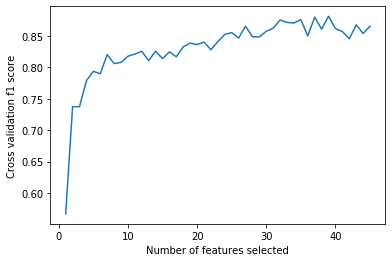

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline


"""
If you use Jupyter Notebook, you can use :
%matplotlib notebook      instead of %matplotlib inline
"""
rf_clf = RandomForestClassifier(bootstrap=True, 
                          class_weight=None, 
                          criterion='gini',
                          max_depth=4, 
                          max_features='auto', 
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0, 
                          min_impurity_split=None,
                          min_samples_leaf=5,
                          min_weight_fraction_leaf=0.0, 
                          n_estimators=100, 
                          n_jobs=16,
                          oob_score=False, 
                          random_state=893717398, 
                          warm_start=False)


rfecv = RFECV(estimator=rf_clf, 
              step=1, 
              cv=5, 
              scoring='f1', 
              n_jobs=16)


rfe = rfecv.fit(x_train, y_train)
print(rfe.n_features_) #Display the optimal number of variable
#print(rfe.support_)
print(rfe.ranking_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation f1 score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [45]:
# See the detail of the values of plot to decide on value of n_features_to_select
res = list(zip (range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_))
#print(res)
nb_features = 12
rfe_sel= RFE(estimator=rf_clf,step=1,n_features_to_select=nb_features) 
rfe_sel_fit = rfe_sel.fit(x_train, y_train)

#print(rfe_sel_fit.support_)
#print(rfe_sel_fit.ranking_)

x_train_var = x_train[x_train.columns[rfe_sel_fit.get_support(indices=True)]]

# Display the columns names
x_train_var.columns

Index(['amount', 'payments', 'meses_trans', 'avg_wage_trans', 'fout_sum',
       'balance_sum', 'avg_amt_ntrans', 'avg_nr_ptrans', 'avg_amt_ptrans',
       'avg_house', 'risk_trans', 'nr_rtrans'],
      dtype='object')

## Correlações

In [20]:
train_num=predictive_train._get_numeric_data()

#remover as chaves das tabelas
train_num.drop(train_num.columns[train_num.columns.str.contains('_id', na=False)],axis=1,inplace=True)

In [21]:
see_cor=x_train_var.columns

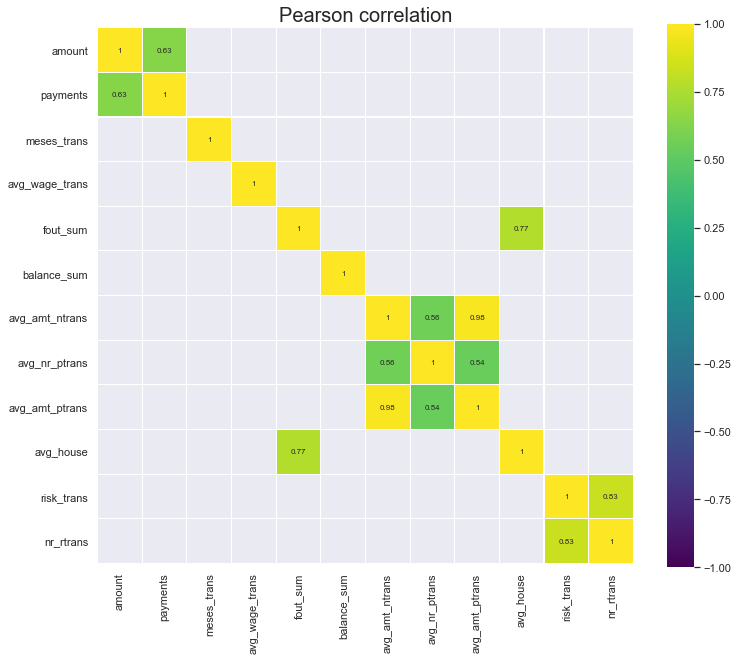

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

corr = train_num[see_cor].corr()
plt.figure(figsize=(12, 10))
plt.title('Pearson correlation', fontsize=20)

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.savefig('correlacao_v2.png')

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,2,3,4,5], 'ccp_alpha':[0,0.001,0.01],'min_samples_leaf':range(5,20),
             'criterion':('gini', 'entropy')}
clf = GridSearchCV(dt, parameters,cv=5)
clf.fit(predictive_train[x_train_var.columns],predictive_train['status'])

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': [0, 0.001, 0.01],
                         'criterion': ('gini', 'entropy'),
            

In [50]:
clf.best_params_

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}

In [54]:
dt=DecisionTreeClassifier(random_state=0,ccp_alpha= 0, criterion= 'gini', max_depth= 5, min_samples_leaf= 5)
dt.fit(predictive_train[x_train_var.columns],predictive_train['status'])

DecisionTreeClassifier(ccp_alpha=0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [55]:
from sklearn.tree import plot_tree, export_text

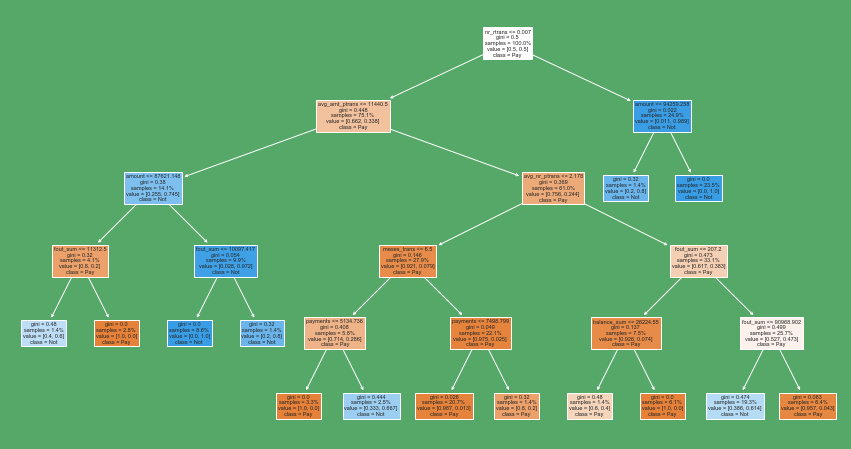

In [56]:
fig, ax = plt.subplots(figsize=(15, 8), facecolor='g')
plot_tree(dt,feature_names=x_train_var.columns, class_names=['Pay','Not'], filled=True, proportion=True, ax=ax);
plt.show()

In [57]:
from sklearn.model_selection import cross_val_score
cross_val_score(dt,predictive_train[x_train_var.columns],predictive_train['status'],cv=5,scoring='accuracy').mean()

0.8178843226788433

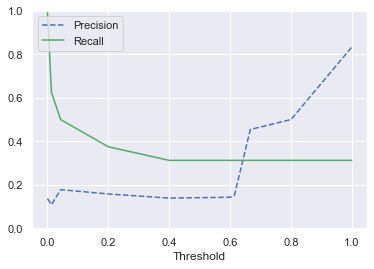

In [58]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

dt_prob = dt.predict_proba(predictive_test[x_train_var.columns])
# retrieve just the probabilities for the positive class
dt_prob1 = dt_prob[:, 1]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

p, r, thresholds = precision_recall_curve(predictive_test['status'], dt_prob1)
plot_precision_recall_vs_threshold(p,r,thresholds)

In [61]:
dt_pred=dt.predict(predictive_test[x_train_var.columns])

from sklearn.metrics import confusion_matrix
confusion_matrix(predictive_test['status'], (dt.predict_proba(predictive_test[x_train_var.columns]) >= 1)[:, 1].astype(int))

array([[100,   1],
       [ 11,   5]], dtype=int64)

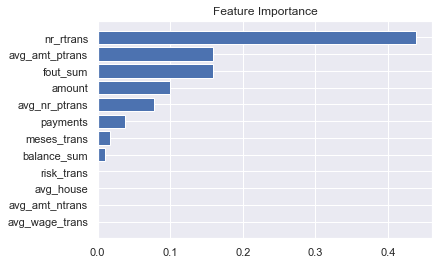

In [62]:
importances_dt = dt.feature_importances_

indices = np.argsort(importances_dt)
names = [x_train_var.columns[i] for i in indices]


plt.figure()
plt.title("Feature Importance")
plt.barh(range(len(x_train_var.columns)), importances_dt[indices])
plt.yticks(range(len(x_train_var.columns)), names, rotation=0)
plt.show()

## Random Forest

In [63]:
rf_clf = RandomForestClassifier(bootstrap=True, 
                          class_weight=None, 
                          max_features='auto', 
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0, 
                          min_impurity_split=None,
                          min_samples_leaf=5,
                          min_weight_fraction_leaf=0.0, 
                          n_jobs=16,
                          oob_score=False, 
                          random_state=0, 
                          warm_start=False)


parameters = {'n_estimators':range(100,301,20), 'max_depth':[4,5,6,7,8],
             'criterion':('gini', 'entropy')}
clf = GridSearchCV(rf_clf, parameters,cv=5)
clf.fit(predictive_train[x_train_var.columns],predictive_train['status'])

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=16,
                                              oob_score=False, random_state=0,
                                     

In [64]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 120}

In [65]:
rf= RandomForestClassifier(bootstrap=True, 
                          class_weight=None, 
                          max_features='auto', 
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0, 
                          min_impurity_split=None,
                          min_samples_leaf=5,
                          min_weight_fraction_leaf=0.0, 
                          n_jobs=16,
                          oob_score=False, 
                          random_state=0, 
                          warm_start=False,
                            criterion='gini', 
                            max_depth=8,
                            n_estimators=120)

In [66]:
rf.fit(predictive_train[x_train_var.columns],predictive_train['status'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=16, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [67]:
cross_val_score(rf,predictive_train[x_train_var.columns],predictive_train['status'],cv=5,scoring='accuracy').mean()

0.897869101978691

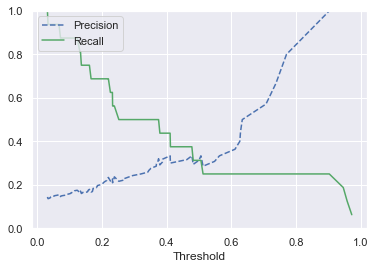

In [68]:
rf_prob = rf.predict_proba(predictive_test[x_train_var.columns])
# retrieve just the probabilities for the positive class
rf_prob1 = rf_prob[:, 1]

p, r, thresholds = precision_recall_curve(predictive_test['status'], rf_prob1)
plot_precision_recall_vs_threshold(p,r,thresholds)

In [69]:
rf_pred=rf.predict(predictive_test[x_train_var.columns])

confusion_matrix(predictive_test['status'], (rf.predict_proba(predictive_test[x_train_var.columns]) >= 0.9)[:, 1].astype(int))

array([[101,   0],
       [ 12,   4]], dtype=int64)

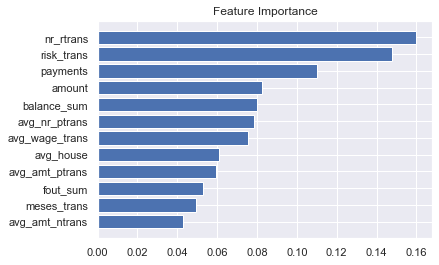

In [70]:
importances_rf = rf.feature_importances_

indices = np.argsort(importances_rf)
names = [x_train_var.columns[i] for i in indices]


plt.figure()
plt.title("Feature Importance")
plt.barh(range(len(x_train_var.columns)), importances_rf[indices])
plt.yticks(range(len(x_train_var.columns)), names, rotation=0)
plt.show()

## Regressão Logística

In [71]:
#Tratar correlações (mantenho a variável com + importância nos outros modelos)
x_train_var.columns

Index(['amount', 'payments', 'meses_trans', 'avg_wage_trans', 'fout_sum',
       'balance_sum', 'avg_amt_ntrans', 'avg_nr_ptrans', 'avg_amt_ptrans',
       'avg_house', 'risk_trans', 'nr_rtrans'],
      dtype='object')

In [72]:
xtrain_rlog=predictive_train[['payments', 'avg_wage_trans', 'meses_trans',
       'fout_sum', 'balance_sum', 
       'avg_amt_ptrans', 'risk_trans']]
xtest_rlog=predictive_test[['payments', 'avg_wage_trans', 'meses_trans',
       'fout_sum', 'balance_sum', 
       'avg_amt_ptrans', 'risk_trans']]

In [116]:
from sklearn.linear_model import LogisticRegression
rlog = LogisticRegression(random_state=0)

parameters = {'C':[0.01,0.1,0.3,0.6,1,2,2.5,3],
             'solver':('liblinear', 'lbfgs')}
clf = GridSearchCV(rlog, parameters,cv=5,scoring='f1')
clf.fit(xtrain_rlog,predictive_train['status'])
clf.best_params_

{'C': 0.01, 'solver': 'lbfgs'}

In [117]:
rlog = LogisticRegression(random_state=0,C=0.01,solver='lbfgs')
rlog.fit(xtrain_rlog,predictive_train['status'])

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
cross_val_score(rlog,xtrain_rlog,predictive_train['status'],cv=5,scoring='accuracy').mean()

0.7680365296803652

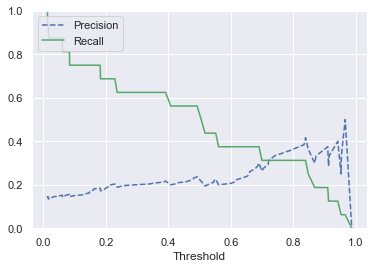

In [119]:
rlog_prob = rlog.predict_proba(xtest_rlog)
# retrieve just the probabilities for the positive class
rlog_prob1 = rlog_prob[:, 1]

p, r, thresholds = precision_recall_curve(predictive_test['status'], rlog_prob1)
plot_precision_recall_vs_threshold(p,r,thresholds)

In [76]:
rlog_pred=rlog.predict(xtest_rlog)

confusion_matrix(predictive_test['status'], (rlog.predict_proba(xtest_rlog) >= 0.82)[:, 1].astype(int))

array([[93,  8],
       [11,  5]], dtype=int64)

In [77]:
xtest_rlog.columns

Index(['payments', 'avg_wage_trans', 'meses_trans', 'fout_sum', 'balance_sum',
       'avg_amt_ptrans', 'risk_trans'],
      dtype='object')

In [78]:
rlog.coef_ 

array([[ 4.56037411e-04, -1.09321399e-04,  4.90437751e-07,
        -2.53920902e-05, -5.11062818e-05,  3.16742124e-05,
         7.29902671e-08]])

In [79]:
rlog.intercept_

array([5.31911997e-08])

## CatBoost

In [80]:
train_data2=predictive_train[x_train_var.columns]
train_labels2=predictive_train['status']
cat_features2=[]
cat_index2=[]
test_data2=predictive_test[x_train_var.columns]
test_labels2=predictive_test['status']

In [81]:
from catboost import CatBoostClassifier, Pool, cv
model = CatBoostClassifier(eval_metric='Logloss', random_seed=0)
grid = {'learning_rate': [0.01, 0.03, 0.06, 0.1,0.15,0.2],
        'depth': [4,5,6,7,8],
       'n_estimators':range(100,301,20)}
model.grid_search(grid,X=train_data2,y=train_labels2,cv=5);

0:	loss: 0.4181262	best: 0.4181262 (0)	total: 265ms	remaining: 1m 27s
1:	loss: 0.3284069	best: 0.3284069 (1)	total: 375ms	remaining: 1m 1s
2:	loss: 0.2646692	best: 0.2646692 (2)	total: 487ms	remaining: 53.1s
3:	loss: 0.2620294	best: 0.2620294 (3)	total: 605ms	remaining: 49.3s
4:	loss: 0.2501348	best: 0.2501348 (4)	total: 696ms	remaining: 45.2s
5:	loss: 0.2806693	best: 0.2501348 (4)	total: 807ms	remaining: 43.6s
6:	loss: 0.3992332	best: 0.2501348 (4)	total: 923ms	remaining: 42.6s
7:	loss: 0.3096570	best: 0.2501348 (4)	total: 1.07s	remaining: 43.2s
8:	loss: 0.2646692	best: 0.2501348 (4)	total: 1.22s	remaining: 43.4s
9:	loss: 0.2591067	best: 0.2501348 (4)	total: 1.32s	remaining: 42.4s
10:	loss: 0.2501348	best: 0.2501348 (4)	total: 1.46s	remaining: 42.3s
11:	loss: 0.2806693	best: 0.2501348 (4)	total: 1.61s	remaining: 42.6s
12:	loss: 0.3825930	best: 0.2501348 (4)	total: 1.87s	remaining: 45.5s
13:	loss: 0.3007915	best: 0.2501348 (4)	total: 2.09s	remaining: 47.2s
14:	loss: 0.2624125	best: 0.2

In [82]:
model.get_params()

{'random_seed': 0,
 'eval_metric': 'Logloss',
 'depth': 6,
 'iterations': 120,
 'learning_rate': 0.1}

In [83]:
catb = CatBoostClassifier(eval_metric='Logloss', random_seed=0,n_estimators=120,learning_rate=0.1,depth=6)
catb.fit(train_data2,train_labels2, plot=True, eval_set=(test_data2, test_labels2))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6596232	test: 0.6708794	best: 0.6708794 (0)	total: 5.68ms	remaining: 676ms
1:	learn: 0.6300193	test: 0.6471933	best: 0.6471933 (1)	total: 8.04ms	remaining: 475ms
2:	learn: 0.6040202	test: 0.6269917	best: 0.6269917 (2)	total: 10.4ms	remaining: 405ms
3:	learn: 0.5801316	test: 0.6099541	best: 0.6099541 (3)	total: 12.7ms	remaining: 368ms
4:	learn: 0.5582630	test: 0.5956862	best: 0.5956862 (4)	total: 15ms	remaining: 345ms
5:	learn: 0.5366968	test: 0.5842573	best: 0.5842573 (5)	total: 17.4ms	remaining: 331ms
6:	learn: 0.5148196	test: 0.5717359	best: 0.5717359 (6)	total: 19.7ms	remaining: 318ms
7:	learn: 0.4980702	test: 0.5639116	best: 0.5639116 (7)	total: 22.1ms	remaining: 309ms
8:	learn: 0.4826550	test: 0.5543619	best: 0.5543619 (8)	total: 24.8ms	remaining: 306ms
9:	learn: 0.4660073	test: 0.5472275	best: 0.5472275 (9)	total: 27.2ms	remaining: 299ms
10:	learn: 0.4496962	test: 0.5347950	best: 0.5347950 (10)	total: 29.1ms	remaining: 288ms
11:	learn: 0.4385436	test: 0.5272649	best: 

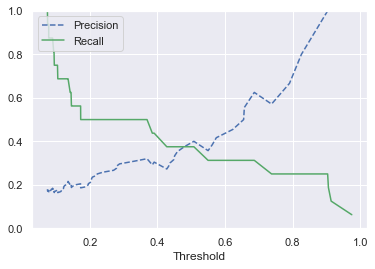

In [84]:
cb_prob = catb.predict_proba(test_data2)
# retrieve just the probabilities for the positive class
cb_prob1 = cb_prob[:, 1]

p, r, thresholds = precision_recall_curve(predictive_test['status'], cb_prob1)
plot_precision_recall_vs_threshold(p,r,thresholds)

In [87]:
cb_pred=catb.predict(test_data2)

confusion_matrix(test_labels2, (cb_prob >= 0.9)[:, 1].astype(int))

array([[101,   0],
       [ 12,   4]], dtype=int64)

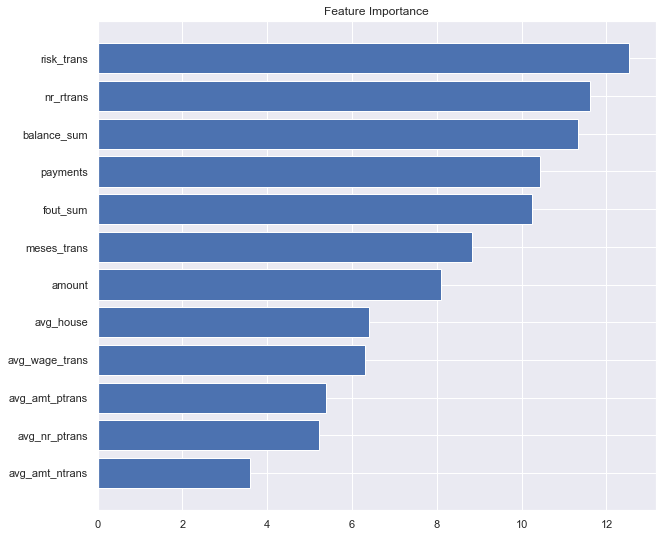

In [89]:
importances_cb = catb.feature_importances_

indices = np.argsort(importances_cb)
names = [test_data2.columns[i] for i in indices]


plt.figure(figsize=(10, 9))
plt.title("Feature Importance")
plt.barh(range(len(test_data2.columns)), importances_cb[indices])
plt.yticks(range(len(test_data2.columns)), names, rotation=0)
plt.show()

## Comparação & Avaliação dos modelos no teste

In [90]:
from sklearn.dummy import DummyClassifier
bl_clf = DummyClassifier(strategy="most_frequent")
bl_clf.fit(predictive_train[x_train_var.columns],predictive_train['status'])

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [91]:
cross_val_score(bl_clf,predictive_train[x_train_var.columns],predictive_train['status'],cv=2,scoring='accuracy').mean()

0.4972375690607735

In [92]:
bl_pred=bl_clf.predict(predictive_test[x_train_var.columns])

In [93]:
bl_prob = bl_clf.predict_proba(predictive_test[x_train_var.columns])
# retrieve just the probabilities for the positive class
bl_prob1 = bl_prob[:, 1]

In [94]:
confusion_matrix(predictive_test['status'], bl_pred)

array([[101,   0],
       [ 16,   0]], dtype=int64)

In [95]:
predictive_test['status'].sum()/len(predictive_test['status'])

0.13675213675213677

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
Model=[' Baseline (bline)','Decision Tree (dt)','Random Forest (rf)','Logistic Regression (rlog)','CatBoost (catb)']

Accuracy_test=[round(accuracy_score(predictive_test['status'], (bl_prob1 >= 0.5).astype(int)),2),
               round(accuracy_score(predictive_test['status'], (dt_prob1 >= 1).astype(int)),2),
              round(accuracy_score(predictive_test['status'], (rf_prob1 >= 0.9).astype(int)),2),
              round(accuracy_score(predictive_test['status'], (rlog_prob1 >= 0.82).astype(int)),2),
              round(accuracy_score(predictive_test['status'], (cb_prob1 >= 0.9).astype(int)),2)]

Precision_test=[round(precision_score(predictive_test['status'], (bl_prob1 >= 0.5).astype(int)),2),
                round(precision_score(predictive_test['status'], (dt_prob1 >= 1).astype(int)),2),
              round(precision_score(predictive_test['status'], (rf_prob1 >= 0.9).astype(int)),2),
              round(precision_score(predictive_test['status'], (rlog_prob1 >= 0.82).astype(int)),2),
              round(precision_score(predictive_test['status'], (cb_prob1 >= 0.9).astype(int)),2)]

Recall_test=[round(recall_score(predictive_test['status'], (bl_prob1 >= 0.5).astype(int)),2),
            round(recall_score(predictive_test['status'], (dt_prob1 >= 1).astype(int)),2),
              round(recall_score(predictive_test['status'], (rf_prob1 >= 0.9).astype(int)),2),
              round(recall_score(predictive_test['status'], (rlog_prob1 >= 0.82).astype(int)),2),
              round(recall_score(predictive_test['status'], (cb_prob1 >= 0.9).astype(int)),2)]

F1_test=[round(f1_score(predictive_test['status'], (bl_prob1 >= 0.5).astype(int)),2),
         round(f1_score(predictive_test['status'], (dt_prob1 >= 1).astype(int)),2),
              round(f1_score(predictive_test['status'], (rf_prob1 >= 0.9).astype(int)),2),
              round(f1_score(predictive_test['status'], (rlog_prob1 >= 0.82).astype(int)),2),
              round(f1_score(predictive_test['status'], (cb_prob1 >= 0.9).astype(int)),2)]

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
metrics=pd.DataFrame({'Model':Model,'Accuracy_test':Accuracy_test,'Precision_test_class1':Precision_test,
                     'Recall_test_class1':Recall_test,'F1_test_class1':F1_test})

In [98]:
metrics

,Model,Accuracy_test,Precision_test_class1,Recall_test_class1,F1_test_class1
0,Baseline (bline),0.86,0.00,0.00,0.00
1,Decision Tree (dt),0.90,0.83,0.31,0.45
2,Random Forest (rf),0.90,1.00,0.25,0.40
3,Logistic Regression (rlog),0.84,0.38,0.31,0.34
4,CatBoost (catb),0.90,1.00,0.25,0.40


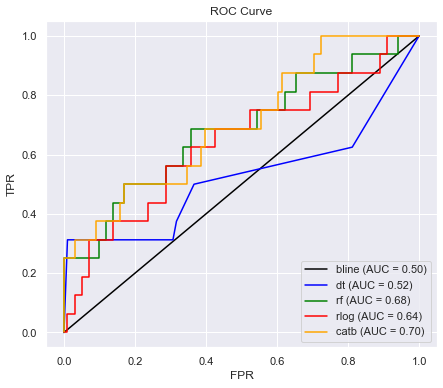

In [99]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(7, 6))

fpr, tpr, _ = roc_curve(predictive_test['status'], bl_prob1)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='black',
                 label='bline (AUC = %0.2f)' % auc_score)

fpr, tpr, _ = roc_curve(predictive_test['status'], dt_prob1)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue',
                 label='dt (AUC = %0.2f)' % auc_score)

fpr, tpr, _ = roc_curve(predictive_test['status'], rf_prob1)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
                 label='rf (AUC = %0.2f)' % auc_score)

fpr, tpr, _ = roc_curve(predictive_test['status'], rlog_prob1)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',
                 label='rlog (AUC = %0.2f)' % auc_score)

fpr, tpr, _ = roc_curve(predictive_test['status'], cb_prob1)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange',
                 label='catb (AUC = %0.2f)' % auc_score)


plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()